In [ ]:
# Installing missing libraries
!pip install datasets
!pip install gensim
!pip install seqeval
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import pandas as pd
import numpy as np
import os
import gensim
import gensim.downloader as api
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from gensim.utils import simple_preprocess
from gensim.models import KeyedVectors
from datasets import load_dataset
from collections import Counter
from itertools import product

In [2]:
# Load Rotten Tomatoes dataset
dataset = load_dataset("rotten_tomatoes")
train_dataset = dataset['train']
validation_dataset = dataset['validation']
test_dataset = dataset['test']

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Derivations from Part 1 and 3.2

In [5]:
# Function to preprocess the text
def preprocess_text(text):
    return simple_preprocess(text, deacc=True)  # deacc = True -> remove accent marks e.g. café to cafe

# Preprocess the training dataset
train_tokens = [preprocess_text(example['text']) for example in train_dataset]

# Iterate through the train dataset tokens and get the unique words to build vocabulary
vocab_counter = Counter([word for tokens in train_tokens for word in tokens])
train_vocab = list(vocab_counter.keys())

# File Path to directory to store the pre-defined models (change as necessary)
model_dir_path = "models"

# Load the Wiki FastText vectors from the .vec file (will take a few minutes to run)
wiki_fasttext_model = KeyedVectors.load_word2vec_format(os.path.join(model_dir_path, "wiki.en.vec"), binary=False)

## Creating the Embedding Matrix from the FastText pretrained vectors

In [23]:
embedding_dim = wiki_fasttext_model.vector_size  # Get the FastText embedding dimension

# Initialize the embedding matrix with zeros
embedding_matrix = np.zeros((len(train_vocab), embedding_dim))

# Fill the embedding matrix
for idx, word in enumerate(train_vocab):
    if word in wiki_fasttext_model:
        # Use FastText embedding
        embedding_matrix[idx] = wiki_fasttext_model[word]  
    else:
        # Random initialisation for out-of-vocabulary (OOV) words
        embedding_matrix[idx] = np.random.normal(scale=0.2, size=(embedding_dim,))

# Print shape of the embedding matrix for debugging
print(f"Embedding matrix shape: {embedding_matrix.shape}")

Embedding matrix shape: (16256, 300)


## Define the SentimentDataset Class and Collate Function

In [11]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, vocab):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Convert each token in the sentence to its corresponding index, 0 for unknown words
        tokens = self.texts[idx].split()
        embedding_indices = [self.vocab.get(word, 0) for word in tokens]
        label = self.labels[idx]

        # Skip any sequences that are effectively empty
        if len(embedding_indices) == 0 or all(index == 0 for index in embedding_indices):
            return None
        return torch.tensor(embedding_indices, dtype=torch.long), torch.tensor(label, dtype=torch.long)


def collate_fn(batch):
    # Filter out None values
    batch = [item for item in batch if item is not None]
    if len(batch) == 0:
        return None, None

    texts, labels = zip(*batch)
    texts = pad_sequence(texts, batch_first=True, padding_value=0)  # Pad sequences with 0
    labels = torch.stack(labels)
    return texts, labels

## Prepare datasets for dataloader

In [ ]:
# Replace these with actual dataset texts and labels
train_texts = train_dataset['text']
train_labels = train_dataset['label']
val_texts = validation_dataset['text']
val_labels = validation_dataset['label']
test_texts = test_dataset['text']
test_labels = test_dataset['label']

# Create vocabulary to index mapping (from Part 1)
vocab_to_index = {word: idx for idx, word in enumerate(train_vocab)}

# Instantiate datasets
train_data = SentimentDataset(train_texts, train_labels, vocab_to_index)
val_data = SentimentDataset(val_texts, val_labels, vocab_to_index)
test_data = SentimentDataset(test_texts, test_labels, vocab_to_index)

# Part 3.3 and 3.4: Implement biLSTM, biGRU, and CNN Models

We'll make the embeddings layer trainable by setting freeze=False, which allows the model to update embeddings during training.

We have decided to use the following models for our training and analysis:
- ```BiLSTM```
- ```BiLSTM with dropout```
- ```BiGRU```
- ```CNN```

For BiLSTM, BiLSTM with dropout, and BiGRU we will ```stack multiple layers from a range of 2 to 4``` and analyse the difference in accuracy scores to determine whether the increase in number of layers will improve the model's accuracy

In [97]:
# Define the biLSTM model without dropout
class SentimentBiLSTM(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, output_dim, num_layers):
        super(SentimentBiLSTM, self).__init__()
        num_embeddings, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=False)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, text):
        lengths = (text != 0).sum(dim=1)
        lengths, perm_idx = lengths.sort(0, descending=True)
        text = text[perm_idx]

        embedded = self.embedding(text)
        packed_embedded = pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=True)
        packed_output, (hidden, _) = self.lstm(packed_embedded)
        hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        return self.fc(hidden[perm_idx.argsort()])


# Define the biGRU model without dropout
class SentimentBiGRU(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, output_dim, num_layers):
        super(SentimentBiGRU, self).__init__()
        num_embeddings, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=False)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=num_layers, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, text):
        lengths = (text != 0).sum(dim=1)
        lengths, perm_idx = lengths.sort(0, descending=True)
        text = text[perm_idx]

        embedded = self.embedding(text)
        packed_embedded = pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=True)
        packed_output, hidden = self.gru(packed_embedded)
        hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        return self.fc(hidden[perm_idx.argsort()])

# Define the biLSTM with Dropout model
class SentimentBiLSTMWithDropout(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, output_dim, num_layers, dropout=0.5):
        super(SentimentBiLSTMWithDropout, self).__init__()
        num_embeddings, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=False)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers,
                            bidirectional=True, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, text):
        lengths = (text != 0).sum(dim=1)
        lengths, perm_idx = lengths.sort(0, descending=True)
        text = text[perm_idx]

        embedded = self.embedding(text)
        packed_embedded = pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=True)
        packed_output, (hidden, _) = self.lstm(packed_embedded)
        hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        hidden = self.dropout(hidden)
        return self.fc(hidden[perm_idx.argsort()])
    
# Define the CNN model without dropout
class SentimentCNN(nn.Module):
    def __init__(self, embedding_matrix, output_dim, num_filters=100, filter_sizes=[3, 4, 5]):
        super(SentimentCNN, self).__init__()
        num_embeddings, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=False)
        self.convs = nn.ModuleList([
            nn.Conv2d(1, num_filters, (fs, embedding_dim)) for fs in filter_sizes
        ])
        self.batch_norms = nn.ModuleList([nn.BatchNorm2d(num_filters) for _ in filter_sizes])
        self.fc = nn.Linear(num_filters * len(filter_sizes), output_dim)

    def forward(self, text):
        embedded = self.embedding(text).unsqueeze(1)
        conved = [torch.relu(self.batch_norms[i](conv(embedded))).squeeze(3) for i, conv in enumerate(self.convs)]
        pooled = [torch.max(conv, dim=2)[0] for conv in conved]
        cat = torch.cat(pooled, dim=1)
        return self.fc(cat)



## Training and Evaluation Functions

In [77]:
# Function to save model
def save_model(model, model_save_path):
    try:
        # Save the model directly (it overwrites the file if it exists)
        torch.save(model.state_dict(), model_save_path)
        print("Model saved.")
    except Exception as e:
        print(f"Failed to save model to {model_save_path}: {e}")

# Training function
def train(model, loader, optimizer, criterion, scheduler=None, max_grad_norm=5.0):
    model.train()
    total_loss, total_correct = 0, 0
    for texts, labels in loader:
        if texts is None or labels is None:
            continue
        texts, labels = texts.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()

        total_loss += loss.item()
        total_correct += (outputs.argmax(1) == labels).sum().item()

    if scheduler:
        scheduler.step()

    return total_loss / len(loader), total_correct / len(loader.dataset)

# Evaluation function
def evaluate(model, loader, criterion):
    model.eval()
    total_loss, total_correct = 0, 0
    with torch.no_grad():
        for texts, labels in loader:
            if texts is None or labels is None:
                continue
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            total_correct += (outputs.argmax(1) == labels).sum().item()
    return total_loss / len(loader), total_correct / len(loader.dataset)

# Function for the whole model training and evaluation process
def train_and_evaluate(
    model,
    train_loader,
    test_loader,
    val_loader,
    optimizer,
    criterion,
    scheduler,
    epochs=100,
    early_stopping_patience=10,
    model_type=None,
    load_best_model=False
):
    print(f"Training with Selected Model: {model_type}")

    best_val_accuracy = 0
    no_improve_epochs = 0

    # Initialising Data Structures
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []
    val_losses, val_accuracies = [], []

    # Train the model within specified number of epochs
    for epoch in range(epochs):

        train_loss, train_accuracy = train(model, train_loader, optimizer, criterion)
        test_loss, test_accuracy = evaluate(model, test_loader, criterion)
        val_loss, val_accuracy = evaluate(model, val_loader, criterion)

        # Append values to list
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Print epoch metrics
        print(f"\nEpoch {epoch + 1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

        # Adjust the learning rate based on the validation loss
        scheduler.step(val_loss)

        # Early stopping logic
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            no_improve_epochs = 0
            save_model(model, os.path.join(os.getcwd(), f'best_model_{model_type}.pt'))
        else:
            no_improve_epochs += 1
            print(f"No improvement for {no_improve_epochs} epochs.")
            if no_improve_epochs >= early_stopping_patience:
                print(f"Early stopping triggered at epoch {epoch+1} due to no improvement.")
                break
    
    # Load the best model
    if load_best_model:
        path = os.path.join(os.getcwd(), f'best_model_{model_type}.pt')
        with open(path, 'rb') as f:
            model.load_state_dict(torch.load(f))
        print("Best Model Loaded.")

    return train_losses, train_accuracies, test_losses, test_accuracies, val_losses, val_accuracies

In [24]:
# Function to create the plots for analysis
def plot_metrics(train_losses, train_accuracies, test_losses, test_accuracies, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(15, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', marker = 'o', color = 'blue')
    plt.plot(epochs, test_losses, label='Test Loss', marker = 'o', color = 'green')
    plt.plot(epochs, val_losses, label='Validation Loss', marker = 'o', color = 'red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epochs')
    plt.legend()
    plt.grid(True)

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy', marker = 'o', color = 'blue')
    plt.plot(epochs, test_accuracies, label='Test Accuracy', marker = 'o', color = 'green')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker = 'o', color = 'red')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Epochs')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

## Initialize parameters and prepare DataLoaders

In this case, we changed our ```learning rate = 0.0001``` as we experienced overfitting when using the ```learning rate = 0.001``` during the training of the RNN model

In [ ]:
# Adjusted hyperparameters based on Part 2
batch_size = 32
hidden_dim = 128  # Reduced hidden dimension
output_dim = 2    # Binary classification (positive/negative sentiment)
learning_rate = 0.0001 # Reduced learning rate to prevent overfitting
weight_decay = 1e-4
epochs = 100

In [27]:
# Data loaders with collate function
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_data, batch_size=batch_size, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=batch_size, collate_fn=collate_fn)

# BiLSTM with 2 Layers

In [106]:
# Initalise the model type
model_type = "BiLSTM (2 Layers)"

# Number of layers for the BiLSTM model
num_layers = 2

# Initialize the BiLSTM model without dropout
bilstm_2_model = SentimentBiLSTM(embedding_matrix, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)

# Set up optimizer, criterion, and scheduler
optimizer = optim.Adam(bilstm_2_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

In [107]:
# Train the model with early stopping
train_losses, train_accuracies, test_losses, test_accuracies, val_losses, val_accuracies = train_and_evaluate(
    bilstm_2_model,
    train_loader,
    test_loader,
    val_loader,
    optimizer,
    criterion,
    scheduler,
    epochs,
    early_stopping_patience=5,
    model_type=model_type,
    load_best_model=True)

Training with Selected Model: BiLSTM (2 Layers)

Epoch 1/50
Train Loss: 0.6541, Train Accuracy: 0.6220
Test Loss: 0.5769, Test Accuracy: 0.7083
Val Loss: 0.5748, Val Accuracy: 0.6942
Model saved.

Epoch 2/50
Train Loss: 0.5350, Train Accuracy: 0.7339
Test Loss: 0.5370, Test Accuracy: 0.7270
Val Loss: 0.5397, Val Accuracy: 0.7205
Model saved.

Epoch 3/50
Train Loss: 0.4698, Train Accuracy: 0.7789
Test Loss: 0.5161, Test Accuracy: 0.7420
Val Loss: 0.5265, Val Accuracy: 0.7270
Model saved.

Epoch 4/50
Train Loss: 0.4168, Train Accuracy: 0.8107
Test Loss: 0.5092, Test Accuracy: 0.7495
Val Loss: 0.5232, Val Accuracy: 0.7326
Model saved.

Epoch 5/50
Train Loss: 0.3641, Train Accuracy: 0.8392
Test Loss: 0.5430, Test Accuracy: 0.7402
Val Loss: 0.5720, Val Accuracy: 0.7392
Model saved.

Epoch 6/50
Train Loss: 0.3095, Train Accuracy: 0.8710
Test Loss: 0.5590, Test Accuracy: 0.7467
Val Loss: 0.5867, Val Accuracy: 0.7383
No improvement for 1 epochs.

Epoch 7/50
Train Loss: 0.2488, Train Accuracy: 

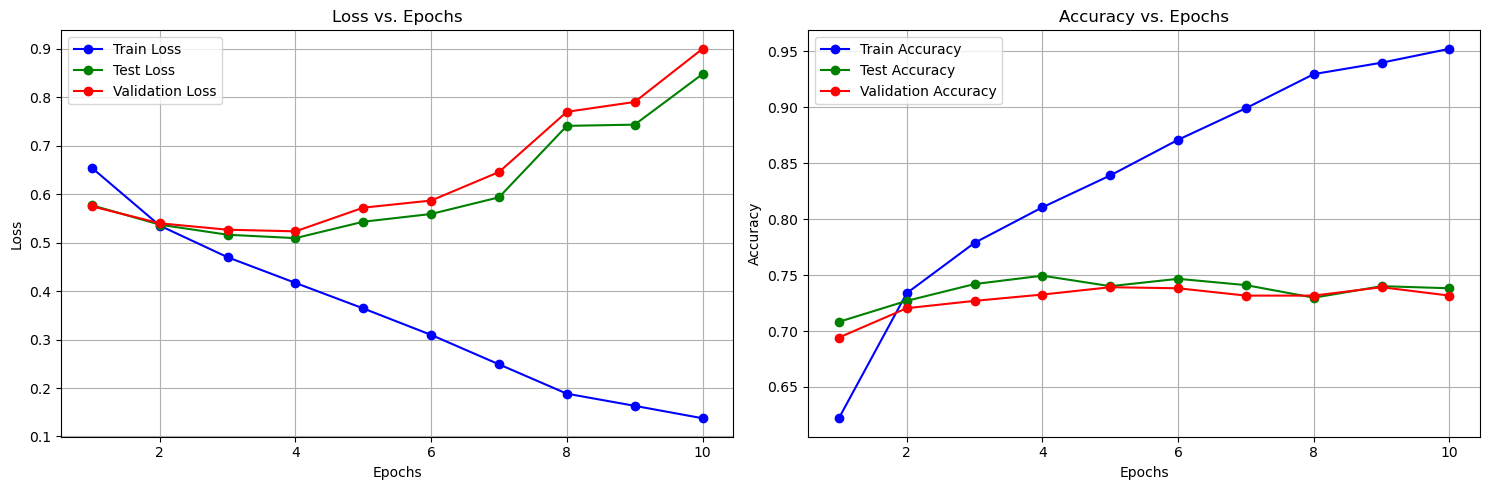

In [108]:
# Plotting Loss and Accuracy against Epochs
plot_metrics(train_losses, train_accuracies, test_losses, test_accuracies, val_losses, val_accuracies)

In [109]:
# Final evaluation on the validation set to compare whether model is correct
bilstm_2_val_loss, bilstm_2_val_accuracy = evaluate(bilstm_2_model, val_loader, criterion)
print(f"Validation Loss: {bilstm_2_val_loss:.4f}, Validation Accuracy: {bilstm_2_val_accuracy:.4f}")

Validation Loss: 0.5720, Validation Accuracy: 0.7392


In [110]:
# Final evaluation on the test set
bilstm_2_test_loss, bilstm_2_test_accuracy = evaluate(bilstm_2_model, test_loader, criterion)
print(f"Test Loss: {bilstm_2_test_loss:.4f}, Test Accuracy: {bilstm_2_test_accuracy:.4f}")

Test Loss: 0.5430, Test Accuracy: 0.7402


# BiLSTM with 3 Layers

In [111]:
# Initalise the model type
model_type = "BiLSTM (3 Layers)"

# Number of layers for the BiLSTM model
num_layers = 3

# Initialize the BiLSTM model without dropout
bilstm_3_model = SentimentBiLSTM(embedding_matrix, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)

# Set up optimizer, criterion, and scheduler
optimizer = optim.Adam(bilstm_3_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

In [112]:
# Train the model with early stopping
train_losses, train_accuracies, test_losses, test_accuracies, val_losses, val_accuracies = train_and_evaluate(
    bilstm_3_model,
    train_loader,
    test_loader,
    val_loader,
    optimizer,
    criterion,
    scheduler,
    epochs,
    early_stopping_patience=5,
    model_type=model_type,
    load_best_model=True)

Training with Selected Model: BiLSTM (3 Layers)

Epoch 1/50
Train Loss: 0.6547, Train Accuracy: 0.6036
Test Loss: 0.5955, Test Accuracy: 0.6857
Val Loss: 0.5967, Val Accuracy: 0.6886
Model saved.

Epoch 2/50
Train Loss: 0.5343, Train Accuracy: 0.7329
Test Loss: 0.5306, Test Accuracy: 0.7402
Val Loss: 0.5365, Val Accuracy: 0.7186
Model saved.

Epoch 3/50
Train Loss: 0.4700, Train Accuracy: 0.7785
Test Loss: 0.5202, Test Accuracy: 0.7411
Val Loss: 0.5332, Val Accuracy: 0.7402
Model saved.

Epoch 4/50
Train Loss: 0.4142, Train Accuracy: 0.8132
Test Loss: 0.5190, Test Accuracy: 0.7486
Val Loss: 0.5439, Val Accuracy: 0.7392
No improvement for 1 epochs.

Epoch 5/50
Train Loss: 0.3583, Train Accuracy: 0.8438
Test Loss: 0.5347, Test Accuracy: 0.7420
Val Loss: 0.5739, Val Accuracy: 0.7392
No improvement for 2 epochs.

Epoch 6/50
Train Loss: 0.2992, Train Accuracy: 0.8755
Test Loss: 0.5631, Test Accuracy: 0.7439
Val Loss: 0.6211, Val Accuracy: 0.7317
No improvement for 3 epochs.

Epoch 7/50
Trai

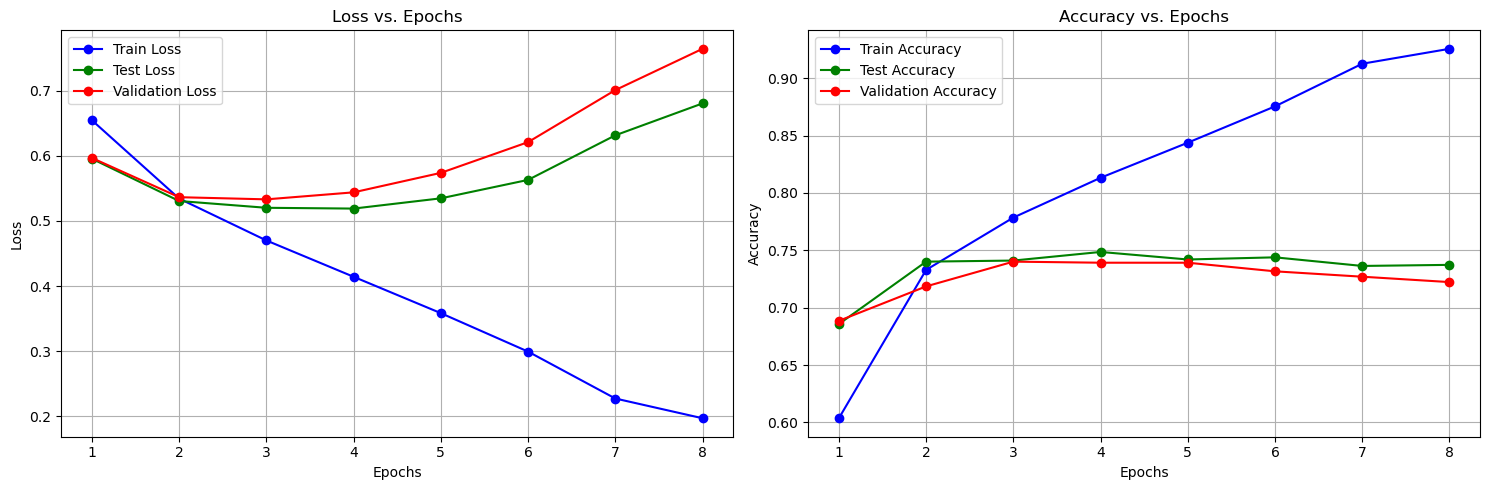

In [113]:
# Plotting Loss and Accuracy against Epochs
plot_metrics(train_losses, train_accuracies, test_losses, test_accuracies, val_losses, val_accuracies)

In [115]:
# Final evaluation on the validation set to compare whether model is correct
bilstm_3_val_loss, bilstm_3_val_accuracy = evaluate(bilstm_3_model, val_loader, criterion)
print(f"Validation Loss: {bilstm_3_val_loss:.4f}, Validation Accuracy: {bilstm_3_val_accuracy:.4f}")

Validation Loss: 0.5332, Validation Accuracy: 0.7402


In [116]:
# Final evaluation on the test set
bilstm_3_test_loss, bilstm_3_test_accuracy = evaluate(bilstm_3_model, test_loader, criterion)
print(f"Test Loss: {bilstm_3_test_loss:.4f}, Test Accuracy: {bilstm_3_test_accuracy:.4f}")

Test Loss: 0.5202, Test Accuracy: 0.7411


# BiLSTM with 4 Layers

In [119]:
# Initalise the model type
model_type = "BiLSTM (4 Layers)"

# Number of layers for the BiLSTM model
num_layers = 4

# Initialize the BiLSTM model without dropout
bilstm_4_model = SentimentBiLSTM(embedding_matrix, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)

# Set up optimizer, criterion, and scheduler
optimizer = optim.Adam(bilstm_4_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

In [120]:
# Train the model with early stopping
train_losses, train_accuracies, test_losses, test_accuracies, val_losses, val_accuracies = train_and_evaluate(
    bilstm_4_model,
    train_loader,
    test_loader,
    val_loader,
    optimizer,
    criterion,
    scheduler,
    epochs,
    early_stopping_patience=5,
    model_type=model_type,
    load_best_model=True)

Training with Selected Model: BiLSTM (4 Layers)

Epoch 1/50
Train Loss: 0.6647, Train Accuracy: 0.5687
Test Loss: 0.5867, Test Accuracy: 0.6895
Val Loss: 0.5867, Val Accuracy: 0.6857
Model saved.

Epoch 2/50
Train Loss: 0.5419, Train Accuracy: 0.7292
Test Loss: 0.5321, Test Accuracy: 0.7402
Val Loss: 0.5343, Val Accuracy: 0.7214
Model saved.

Epoch 3/50
Train Loss: 0.4734, Train Accuracy: 0.7754
Test Loss: 0.5288, Test Accuracy: 0.7430
Val Loss: 0.5395, Val Accuracy: 0.7336
Model saved.

Epoch 4/50
Train Loss: 0.4212, Train Accuracy: 0.8124
Test Loss: 0.5160, Test Accuracy: 0.7486
Val Loss: 0.5299, Val Accuracy: 0.7336
No improvement for 1 epochs.

Epoch 5/50
Train Loss: 0.3633, Train Accuracy: 0.8438
Test Loss: 0.5397, Test Accuracy: 0.7477
Val Loss: 0.5667, Val Accuracy: 0.7298
No improvement for 2 epochs.

Epoch 6/50
Train Loss: 0.3132, Train Accuracy: 0.8699
Test Loss: 0.5657, Test Accuracy: 0.7430
Val Loss: 0.6050, Val Accuracy: 0.7270
No improvement for 3 epochs.

Epoch 7/50
Trai

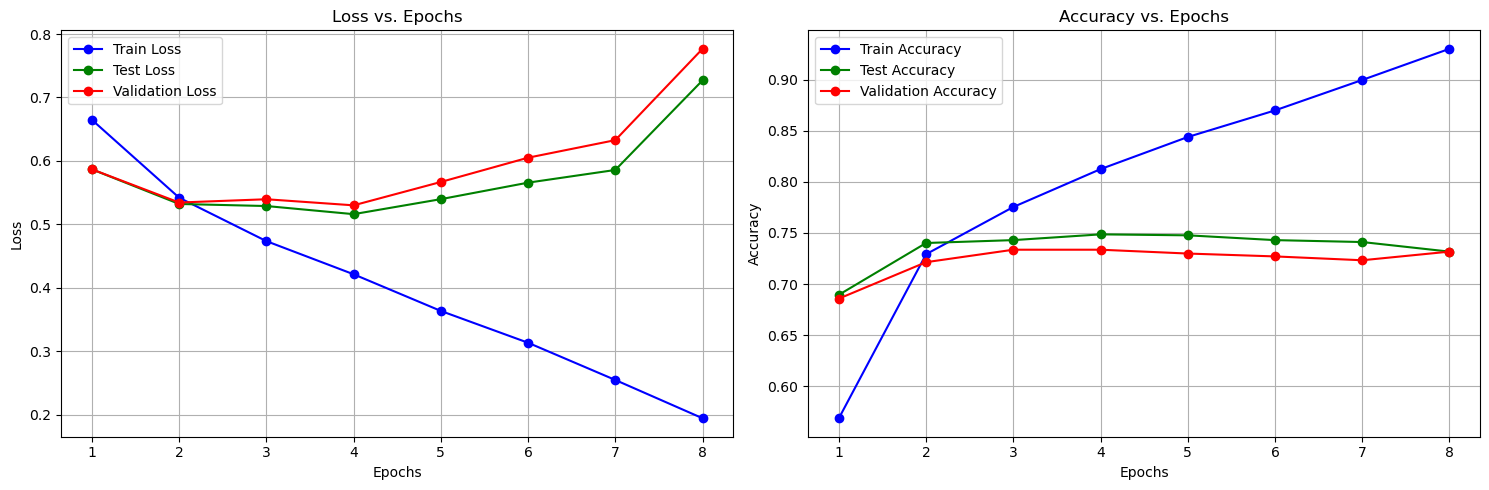

In [121]:
# Plotting Loss and Accuracy against Epochs
plot_metrics(train_losses, train_accuracies, test_losses, test_accuracies, val_losses, val_accuracies)

In [122]:
# Final evaluation on the validation set to compare whether model is correct
bilstm_4_val_loss, bilstm_4_val_accuracy = evaluate(bilstm_4_model, val_loader, criterion)
print(f"Validation Loss: {bilstm_4_val_loss:.4f}, Validation Accuracy: {bilstm_4_val_accuracy:.4f}")

Validation Loss: 0.5395, Validation Accuracy: 0.7336


In [123]:
# Final evaluation on the test set
bilstm_4_test_loss, bilstm_4_test_accuracy = evaluate(bilstm_4_model, test_loader, criterion)
print(f"Test Loss: {bilstm_4_test_loss:.4f}, Test Accuracy: {bilstm_4_test_accuracy:.4f}")

Test Loss: 0.5288, Test Accuracy: 0.7430


# BiGru with 2 Layers

In [134]:
# Initalise the model type
model_type = "BiGRU (2 Layers)"

# Number of layers for the BiGRU model
num_layers = 2

# Initialize the BiGRU model without dropout
bigru_2_model = SentimentBiGRU(embedding_matrix, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)

# Set up optimizer, criterion, and scheduler
optimizer = optim.Adam(bigru_2_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

In [135]:
# Train the model with early stopping
train_losses, train_accuracies, test_losses, test_accuracies, val_losses, val_accuracies = train_and_evaluate(
    bigru_2_model,
    train_loader,
    test_loader,
    val_loader,
    optimizer,
    criterion,
    scheduler,
    epochs,
    early_stopping_patience=5,
    model_type=model_type,
    load_best_model=True)

Training with Selected Model: BiGRU (2 Layers)

Epoch 1/50
Train Loss: 0.6347, Train Accuracy: 0.6338
Test Loss: 0.5844, Test Accuracy: 0.6942
Val Loss: 0.5794, Val Accuracy: 0.6839
Model saved.

Epoch 2/50
Train Loss: 0.5174, Train Accuracy: 0.7374
Test Loss: 0.5385, Test Accuracy: 0.7270
Val Loss: 0.5377, Val Accuracy: 0.7223
Model saved.

Epoch 3/50
Train Loss: 0.4582, Train Accuracy: 0.7810
Test Loss: 0.5209, Test Accuracy: 0.7467
Val Loss: 0.5239, Val Accuracy: 0.7336
Model saved.

Epoch 4/50
Train Loss: 0.4078, Train Accuracy: 0.8127
Test Loss: 0.5132, Test Accuracy: 0.7533
Val Loss: 0.5218, Val Accuracy: 0.7439
Model saved.

Epoch 5/50
Train Loss: 0.3540, Train Accuracy: 0.8436
Test Loss: 0.5292, Test Accuracy: 0.7495
Val Loss: 0.5465, Val Accuracy: 0.7430
No improvement for 1 epochs.

Epoch 6/50
Train Loss: 0.2966, Train Accuracy: 0.8788
Test Loss: 0.5694, Test Accuracy: 0.7392
Val Loss: 0.5826, Val Accuracy: 0.7373
No improvement for 2 epochs.

Epoch 7/50
Train Loss: 0.2457, T

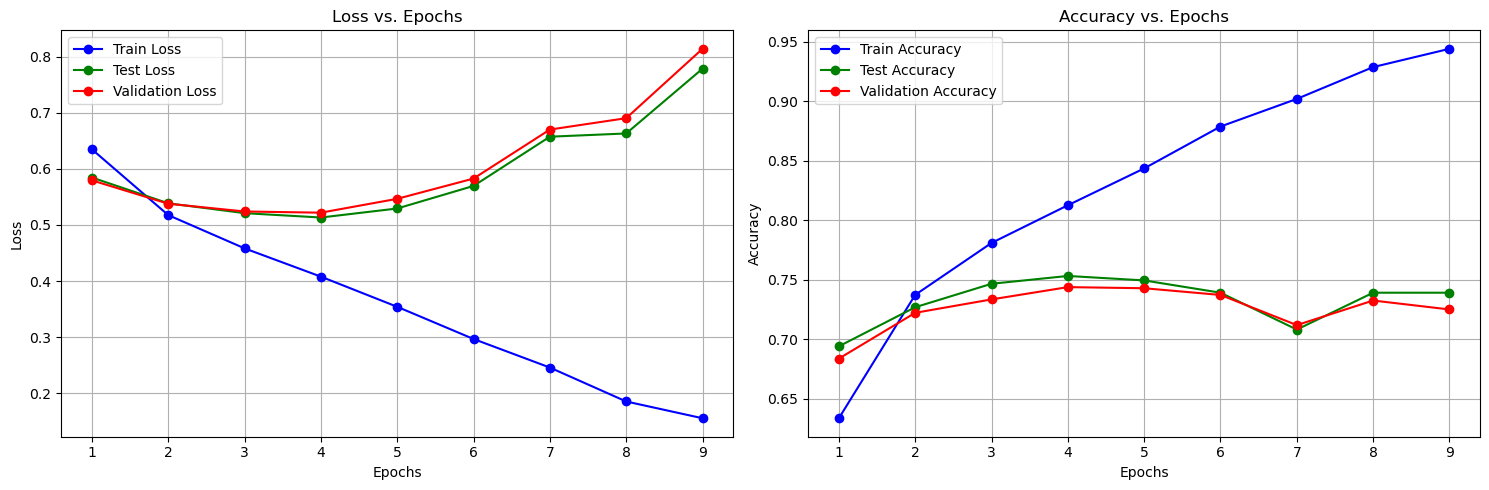

In [139]:
# Plotting Loss and Accuracy against Epochs
plot_metrics(train_losses, train_accuracies, test_losses, test_accuracies, val_losses, val_accuracies)

In [140]:
# Final evaluation on the validation set to compare whether model is correct
bigru_2_val_loss, bigru_2_val_accuracy = evaluate(bigru_2_model, val_loader, criterion)
print(f"Validation Loss: {bigru_2_val_loss:.4f}, Validation Accuracy: {bigru_2_val_accuracy:.4f}")

Validation Loss: 0.5218, Validation Accuracy: 0.7439


In [141]:
# Final evaluation on the test set
bigru_2_test_loss, bigru_2_test_accuracy = evaluate(bigru_2_model, test_loader, criterion)
print(f"Test Loss: {bigru_2_test_loss:.4f}, Test Accuracy: {bigru_2_test_accuracy:.4f}")

Test Loss: 0.5132, Test Accuracy: 0.7533


# BiGRU with 3 Layers

In [129]:
# Initalise the model type
model_type = "BiGRU (3 Layers)"

# Number of layers for the BiGRU model
num_layers = 3

# Initialize the BiGRU model without dropout
bigru_3_model = SentimentBiGRU(embedding_matrix, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)

# Set up optimizer, criterion, and scheduler
optimizer = optim.Adam(bigru_3_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

In [130]:
# Train the model with early stopping
train_losses, train_accuracies, test_losses, test_accuracies, val_losses, val_accuracies = train_and_evaluate(
    bigru_3_model,
    train_loader,
    test_loader,
    val_loader,
    optimizer,
    criterion,
    scheduler,
    epochs,
    early_stopping_patience=5,
    model_type=model_type,
    load_best_model=True)

Training with Selected Model: BiGRU (3 Layers)

Epoch 1/50
Train Loss: 0.6288, Train Accuracy: 0.6338
Test Loss: 0.5511, Test Accuracy: 0.7139
Val Loss: 0.5560, Val Accuracy: 0.7120
Model saved.

Epoch 2/50
Train Loss: 0.5174, Train Accuracy: 0.7408
Test Loss: 0.5250, Test Accuracy: 0.7420
Val Loss: 0.5331, Val Accuracy: 0.7195
Model saved.

Epoch 3/50
Train Loss: 0.4546, Train Accuracy: 0.7858
Test Loss: 0.5160, Test Accuracy: 0.7552
Val Loss: 0.5277, Val Accuracy: 0.7233
Model saved.

Epoch 4/50
Train Loss: 0.4010, Train Accuracy: 0.8176
Test Loss: 0.5095, Test Accuracy: 0.7523
Val Loss: 0.5261, Val Accuracy: 0.7270
Model saved.

Epoch 5/50
Train Loss: 0.3415, Train Accuracy: 0.8516
Test Loss: 0.5875, Test Accuracy: 0.7345
Val Loss: 0.6074, Val Accuracy: 0.7308
Model saved.

Epoch 6/50
Train Loss: 0.2931, Train Accuracy: 0.8764
Test Loss: 0.5752, Test Accuracy: 0.7402
Val Loss: 0.6041, Val Accuracy: 0.7214
No improvement for 1 epochs.

Epoch 7/50
Train Loss: 0.2357, Train Accuracy: 0

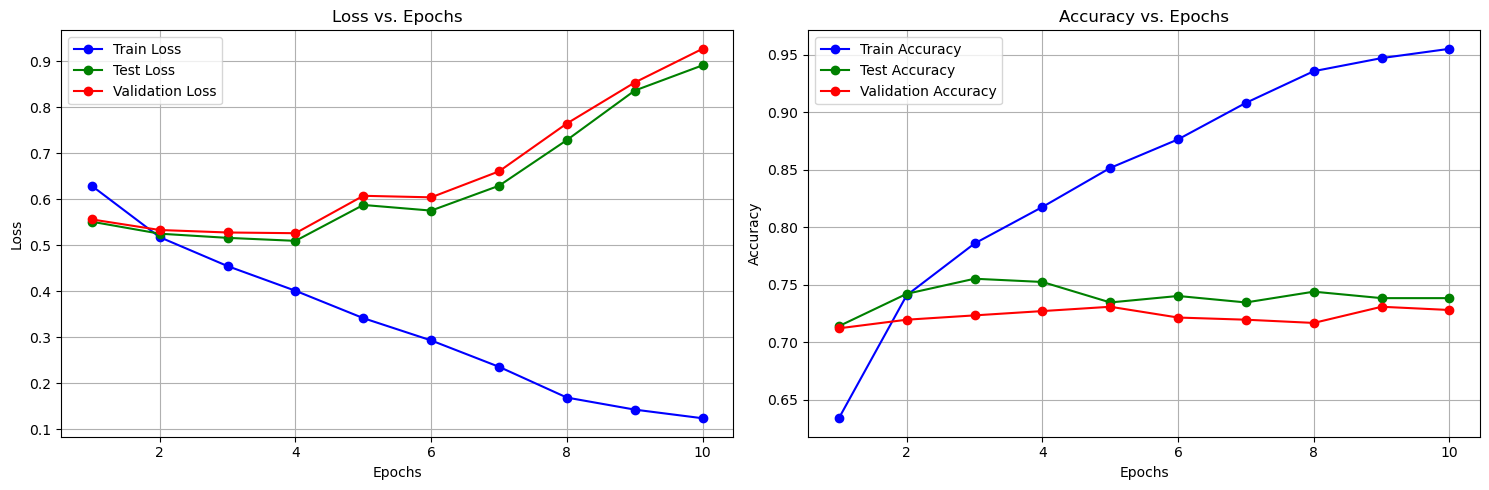

In [131]:
# Plotting Loss and Accuracy against Epochs
plot_metrics(train_losses, train_accuracies, test_losses, test_accuracies, val_losses, val_accuracies)

In [132]:
# Final evaluation on the validation set to compare whether model is correct
bigru_3_val_loss, bigru_3_val_accuracy = evaluate(bigru_3_model, val_loader, criterion)
print(f"Validation Loss: {bigru_3_val_loss:.4f}, Validation Accuracy: {bigru_3_val_accuracy:.4f}")

Validation Loss: 0.6074, Validation Accuracy: 0.7308


In [133]:
# Final evaluation on the test set
bigru_3_test_loss, bigru_3_test_accuracy = evaluate(bigru_3_model, test_loader, criterion)
print(f"Test Loss: {bigru_3_test_loss:.4f}, Test Accuracy: {bigru_3_test_accuracy:.4f}")

Test Loss: 0.5875, Test Accuracy: 0.7345


# BiGRU with 4 Layers

In [142]:
# Initalise the model type
model_type = "BiGRU (4 Layers)"

# Number of layers for the BiGRU model
num_layers = 4

# Initialize the BiGRU model without dropout
bigru_4_model = SentimentBiGRU(embedding_matrix, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)

# Set up optimizer, criterion, and scheduler
optimizer = optim.Adam(bigru_4_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

In [143]:
# Train the model with early stopping
train_losses, train_accuracies, test_losses, test_accuracies, val_losses, val_accuracies = train_and_evaluate(
    bigru_4_model,
    train_loader,
    test_loader,
    val_loader,
    optimizer,
    criterion,
    scheduler,
    epochs,
    early_stopping_patience=5,
    model_type=model_type,
    load_best_model=True)

Training with Selected Model: BiGRU (4 Layers)

Epoch 1/50
Train Loss: 0.6136, Train Accuracy: 0.6562
Test Loss: 0.5691, Test Accuracy: 0.6970
Val Loss: 0.5743, Val Accuracy: 0.7026
Model saved.

Epoch 2/50
Train Loss: 0.5097, Train Accuracy: 0.7488
Test Loss: 0.5298, Test Accuracy: 0.7298
Val Loss: 0.5354, Val Accuracy: 0.7242
Model saved.

Epoch 3/50
Train Loss: 0.4595, Train Accuracy: 0.7819
Test Loss: 0.5253, Test Accuracy: 0.7355
Val Loss: 0.5339, Val Accuracy: 0.7355
Model saved.

Epoch 4/50
Train Loss: 0.4029, Train Accuracy: 0.8188
Test Loss: 0.5234, Test Accuracy: 0.7420
Val Loss: 0.5400, Val Accuracy: 0.7373
Model saved.

Epoch 5/50
Train Loss: 0.3461, Train Accuracy: 0.8484
Test Loss: 0.5681, Test Accuracy: 0.7261
Val Loss: 0.5865, Val Accuracy: 0.7158
No improvement for 1 epochs.

Epoch 6/50
Train Loss: 0.2885, Train Accuracy: 0.8750
Test Loss: 0.6116, Test Accuracy: 0.7402
Val Loss: 0.6375, Val Accuracy: 0.7148
No improvement for 2 epochs.

Epoch 7/50
Train Loss: 0.2159, T

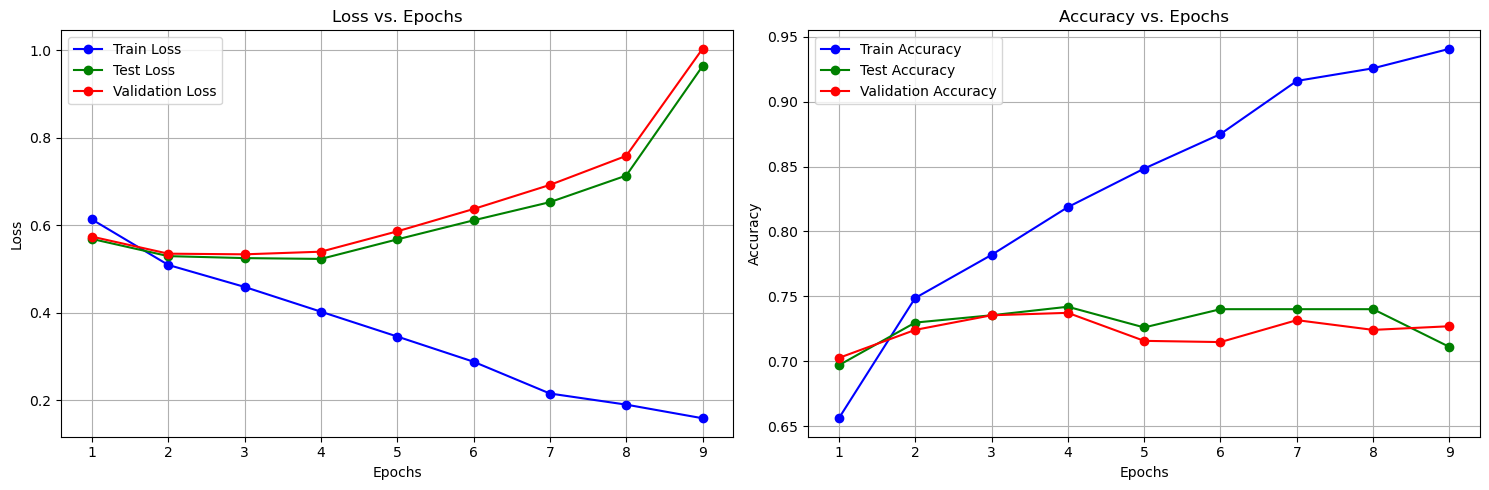

In [144]:
# Plotting Loss and Accuracy against Epochs
plot_metrics(train_losses, train_accuracies, test_losses, test_accuracies, val_losses, val_accuracies)

In [145]:
# Final evaluation on the validation set to compare whether model is correct
bigru_4_val_loss, bigru_4_val_accuracy = evaluate(bigru_4_model, val_loader, criterion)
print(f"Validation Loss: {bigru_4_val_loss:.4f}, Validation Accuracy: {bigru_4_val_accuracy:.4f}")

Validation Loss: 0.5400, Validation Accuracy: 0.7373


In [146]:
# Final evaluation on the test set
bigru_4_test_loss, bigru_4_test_accuracy = evaluate(bigru_4_model, test_loader, criterion)
print(f"Test Loss: {bigru_4_test_loss:.4f}, Test Accuracy: {bigru_4_test_accuracy:.4f}")

Test Loss: 0.5234, Test Accuracy: 0.7420


# BiLSTMWithDropout with 2 Layers


In [ ]:
# Initalise the model type
model_type = "BiLSTM with Dropout"

# Number of layers for the BiLSTM with Dropout model
num_layers = 2

# Initialize the BiLSTM with Dropout model
bilstm_dropout_2_model = SentimentBiLSTMWithDropout(embedding_matrix, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers, dropout=0.5).to(device)

# Set up optimizer, criterion, and scheduler
optimizer = optim.Adam(bilstm_dropout_2_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

In [153]:
# Train the model with early stopping
train_losses, train_accuracies, test_losses, test_accuracies, val_losses, val_accuracies = train_and_evaluate(
    bilstm_dropout_2_model,
    train_loader,
    test_loader,
    val_loader,
    optimizer,
    criterion,
    scheduler,
    epochs,
    early_stopping_patience=5,
    model_type=model_type,
    load_best_model=True)

Training with Selected Model: BiLSTM with Dropout

Epoch 1/50
Train Loss: 0.6824, Train Accuracy: 0.5658
Test Loss: 0.6264, Test Accuracy: 0.6773
Val Loss: 0.6271, Val Accuracy: 0.6623
Model saved.

Epoch 2/50
Train Loss: 0.5706, Train Accuracy: 0.7072
Test Loss: 0.5484, Test Accuracy: 0.7186
Val Loss: 0.5483, Val Accuracy: 0.7073
Model saved.

Epoch 3/50
Train Loss: 0.4861, Train Accuracy: 0.7662
Test Loss: 0.5244, Test Accuracy: 0.7420
Val Loss: 0.5257, Val Accuracy: 0.7298
Model saved.

Epoch 4/50
Train Loss: 0.4318, Train Accuracy: 0.8068
Test Loss: 0.5214, Test Accuracy: 0.7523
Val Loss: 0.5262, Val Accuracy: 0.7392
Model saved.

Epoch 5/50
Train Loss: 0.3764, Train Accuracy: 0.8346
Test Loss: 0.5231, Test Accuracy: 0.7486
Val Loss: 0.5415, Val Accuracy: 0.7280
No improvement for 1 epochs.

Epoch 6/50
Train Loss: 0.3182, Train Accuracy: 0.8686
Test Loss: 0.5802, Test Accuracy: 0.7486
Val Loss: 0.6061, Val Accuracy: 0.7345
No improvement for 2 epochs.

Epoch 7/50
Train Loss: 0.2574

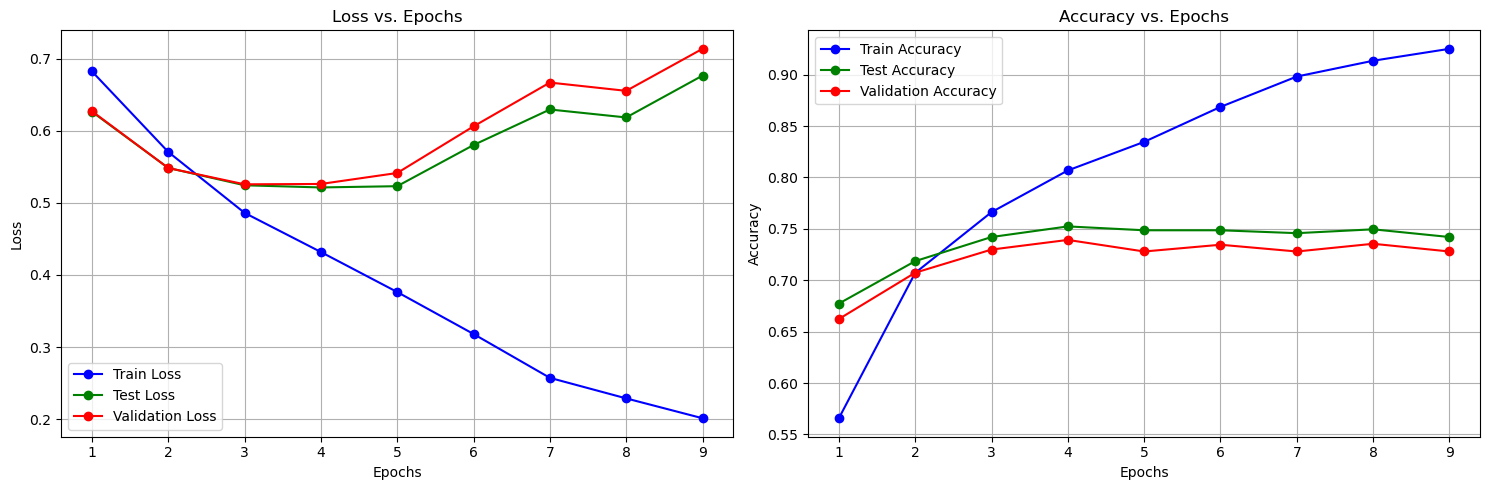

In [154]:
# Plotting Loss and Accuracy against Epochs
plot_metrics(train_losses, train_accuracies, test_losses, test_accuracies, val_losses, val_accuracies)

In [155]:
# Final evaluation on the validation set to compare whether model is correct
bilstm_dropout_2_val_loss, bilstm_dropout_2_val_accuracy = evaluate(bilstm_dropout_2_model, val_loader, criterion)
print(f"Validation Loss: {bilstm_dropout_2_val_loss:.4f}, Validation Accuracy: {bilstm_dropout_2_val_accuracy:.4f}")

Validation Loss: 0.5262, Validation Accuracy: 0.7392


In [172]:
# Final evaluation on the test set
bilstm_dropout_2_test_loss, bilstm_dropout_2_test_accuracy = evaluate(bilstm_dropout_2_model, test_loader, criterion)
print(f"Test Loss: {bilstm_dropout_2_test_loss:.4f}, Test Accuracy: {bilstm_dropout_2_test_accuracy:.4f}")

Test Loss: 0.5214, Test Accuracy: 0.7523


# BiLSTMWithDropout with 3 Layers

In [ ]:
# Initalise the model type
model_type = "BiLSTM with Dropout (3 Layers)"

# Number of layers for the BiLSTM with Dropout model
num_layers = 3

# Initialize the BiLSTM with Dropout model
bilstm_dropout_3_model = SentimentBiLSTMWithDropout(embedding_matrix, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers, dropout=0.5).to(device)

# Set up optimizer, criterion, and scheduler
optimizer = optim.Adam(bilstm_dropout_3_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

In [178]:
# Train the model with early stopping
train_losses, train_accuracies, test_losses, test_accuracies, val_losses, val_accuracies = train_and_evaluate(
    bilstm_dropout_3_model,
    train_loader,
    test_loader,
    val_loader,
    optimizer,
    criterion,
    scheduler,
    epochs,
    early_stopping_patience=5,
    model_type=model_type,
    load_best_model=True)

Training with Selected Model: BiLSTM with Dropout (3 Layers)

Epoch 1/50
Train Loss: 0.6825, Train Accuracy: 0.5644
Test Loss: 0.6144, Test Accuracy: 0.6614
Val Loss: 0.6146, Val Accuracy: 0.6707
Model saved.

Epoch 2/50
Train Loss: 0.5552, Train Accuracy: 0.7185
Test Loss: 0.5355, Test Accuracy: 0.7280
Val Loss: 0.5342, Val Accuracy: 0.7308
Model saved.

Epoch 3/50
Train Loss: 0.4904, Train Accuracy: 0.7652
Test Loss: 0.5192, Test Accuracy: 0.7448
Val Loss: 0.5234, Val Accuracy: 0.7308
No improvement for 1 epochs.

Epoch 4/50
Train Loss: 0.4251, Train Accuracy: 0.8107
Test Loss: 0.5255, Test Accuracy: 0.7392
Val Loss: 0.5375, Val Accuracy: 0.7355
Model saved.

Epoch 5/50
Train Loss: 0.3726, Train Accuracy: 0.8379
Test Loss: 0.5249, Test Accuracy: 0.7533
Val Loss: 0.5431, Val Accuracy: 0.7402
Model saved.

Epoch 6/50
Train Loss: 0.3168, Train Accuracy: 0.8679
Test Loss: 0.5848, Test Accuracy: 0.7467
Val Loss: 0.6058, Val Accuracy: 0.7308
No improvement for 1 epochs.

Epoch 7/50
Train L

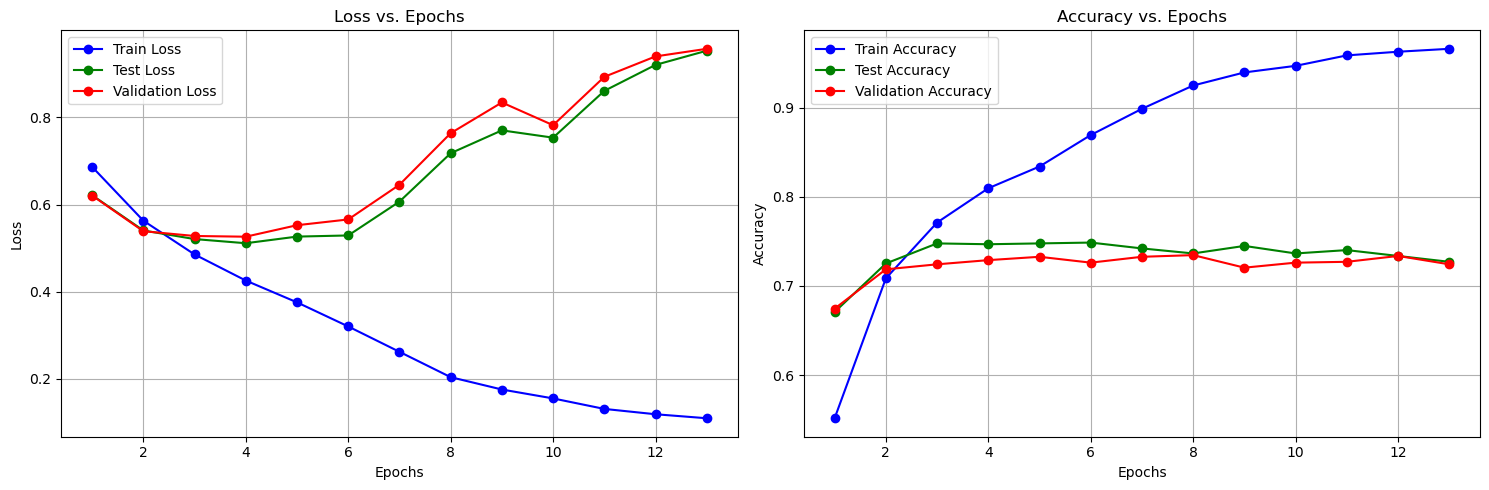

In [161]:
# Plotting Loss and Accuracy against Epochs
plot_metrics(train_losses, train_accuracies, test_losses, test_accuracies, val_losses, val_accuracies)

In [179]:
# Final evaluation on the validation set to compare whether model is correct
bilstm_dropout_3_val_loss, bilstm_dropout_3_val_accuracy = evaluate(bilstm_dropout_3_model, val_loader, criterion)
print(f"Validation Loss: {bilstm_dropout_3_val_loss:.4f}, Validation Accuracy: {bilstm_dropout_3_val_accuracy:.4f}")

Validation Loss: 0.5431, Validation Accuracy: 0.7402


In [181]:
# Final evaluation on the test set
bilstm_dropout_3_test_loss, bilstm_dropout_3_test_accuracy = evaluate(bilstm_dropout_3_model, test_loader, criterion)
print(f"Test Loss: {bilstm_dropout_3_test_loss:.4f}, Test Accuracy: {bilstm_dropout_3_test_accuracy:.4f}")

Test Loss: 0.5249, Test Accuracy: 0.7533


# BiLSTMWithDropout with 4 Layers

In [188]:
# Initalise the model type
model_type = "BiLSTM with Dropout (4 Layers)"

# Number of layers for the BiLSTM with Dropout model
num_layers = 4

# Initialize the BiLSTM with Dropout model
bilstm_dropout_4_model = SentimentBiLSTMWithDropout(embedding_matrix, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers, dropout=0.5).to(device)

# Set up optimizer, criterion, and scheduler
optimizer = optim.Adam(bilstm_dropout_4_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

In [189]:
# Train the model with early stopping
train_losses, train_accuracies, test_losses, test_accuracies, val_losses, val_accuracies = train_and_evaluate(
    bilstm_dropout_4_model,
    train_loader,
    test_loader,
    val_loader,
    optimizer,
    criterion,
    scheduler,
    epochs,
    early_stopping_patience=5,
    model_type=model_type,
    load_best_model=True)

Training with Selected Model: BiLSTM with Dropout (4 Layers)

Epoch 1/50
Train Loss: 0.6924, Train Accuracy: 0.5176
Test Loss: 0.6870, Test Accuracy: 0.5103
Val Loss: 0.6875, Val Accuracy: 0.5028
Model saved.

Epoch 2/50
Train Loss: 0.5942, Train Accuracy: 0.6807
Test Loss: 0.5512, Test Accuracy: 0.7270
Val Loss: 0.5580, Val Accuracy: 0.7233
Model saved.

Epoch 3/50
Train Loss: 0.4964, Train Accuracy: 0.7605
Test Loss: 0.5180, Test Accuracy: 0.7477
Val Loss: 0.5299, Val Accuracy: 0.7261
Model saved.

Epoch 4/50
Train Loss: 0.4355, Train Accuracy: 0.8030
Test Loss: 0.5115, Test Accuracy: 0.7552
Val Loss: 0.5338, Val Accuracy: 0.7326
Model saved.

Epoch 5/50
Train Loss: 0.3784, Train Accuracy: 0.8347
Test Loss: 0.5367, Test Accuracy: 0.7570
Val Loss: 0.5716, Val Accuracy: 0.7364
Model saved.

Epoch 6/50
Train Loss: 0.3197, Train Accuracy: 0.8691
Test Loss: 0.5722, Test Accuracy: 0.7495
Val Loss: 0.6181, Val Accuracy: 0.7233
No improvement for 1 epochs.

Epoch 7/50
Train Loss: 0.2547, Tra

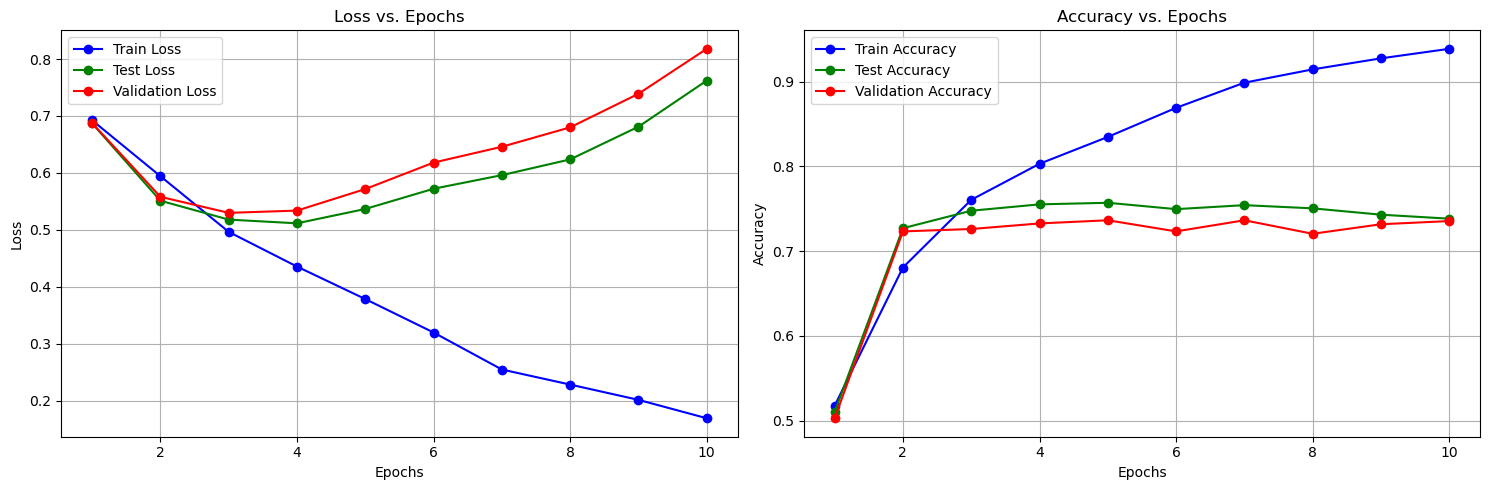

In [190]:
# Plotting Loss and Accuracy against Epochs
plot_metrics(train_losses, train_accuracies, test_losses, test_accuracies, val_losses, val_accuracies)

In [191]:
# Final evaluation on the validation set to compare whether model is correct
bilstm_dropout_4_val_loss, bilstm_dropout_4_val_accuracy = evaluate(bilstm_dropout_4_model, val_loader, criterion)
print(f"Validation Loss: {bilstm_dropout_4_val_loss:.4f}, Validation Accuracy: {bilstm_dropout_4_val_accuracy:.4f}")

Validation Loss: 0.5716, Validation Accuracy: 0.7364


In [192]:
# Final evaluation on the test set
bilstm_dropout_4_test_loss, bilstm_dropout_4_test_accuracy = evaluate(bilstm_dropout_4_model, test_loader, criterion)
print(f"Test Loss: {bilstm_dropout_4_test_loss:.4f}, Test Accuracy: {bilstm_dropout_4_test_accuracy:.4f}")

Test Loss: 0.5367, Test Accuracy: 0.7570


# CNN

In [78]:
# Initalise the model type
model_type = "CNN"

# Initialize the CNN model without dropout
cnn_model = SentimentCNN(embedding_matrix, output_dim=output_dim, num_filters=100, filter_sizes=[3, 4, 5]).to(device)

# Set up optimizer, criterion, and scheduler
optimizer = optim.Adam(cnn_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

In [79]:
# Train the model with early stopping
train_losses, train_accuracies, test_losses, test_accuracies, val_losses, val_accuracies = train_and_evaluate(
    cnn_model,
    train_loader,
    test_loader,
    val_loader,
    optimizer,
    criterion,
    scheduler,
    epochs,
    early_stopping_patience=5,
    model_type=model_type,
    load_best_model=True)

Training with Selected Model: CNN

Epoch 1/50
Train Loss: 0.5683, Train Accuracy: 0.6980
Test Loss: 0.5114, Test Accuracy: 0.7402
Val Loss: 0.5124, Val Accuracy: 0.7448
Model saved.

Epoch 2/50
Train Loss: 0.3423, Train Accuracy: 0.8691
Test Loss: 0.4855, Test Accuracy: 0.7683
Val Loss: 0.4902, Val Accuracy: 0.7627
Model saved.

Epoch 3/50
Train Loss: 0.2055, Train Accuracy: 0.9542
Test Loss: 0.4767, Test Accuracy: 0.7758
Val Loss: 0.4872, Val Accuracy: 0.7702
Model saved.

Epoch 4/50
Train Loss: 0.1165, Train Accuracy: 0.9857
Test Loss: 0.4741, Test Accuracy: 0.7777
Val Loss: 0.4907, Val Accuracy: 0.7739
Model saved.

Epoch 5/50
Train Loss: 0.0678, Train Accuracy: 0.9973
Test Loss: 0.4784, Test Accuracy: 0.7795
Val Loss: 0.5049, Val Accuracy: 0.7739
No improvement for 1 epochs.

Epoch 6/50
Train Loss: 0.0406, Train Accuracy: 0.9992
Test Loss: 0.4920, Test Accuracy: 0.7795
Val Loss: 0.5201, Val Accuracy: 0.7720
No improvement for 2 epochs.

Epoch 7/50
Train Loss: 0.0266, Train Accuracy

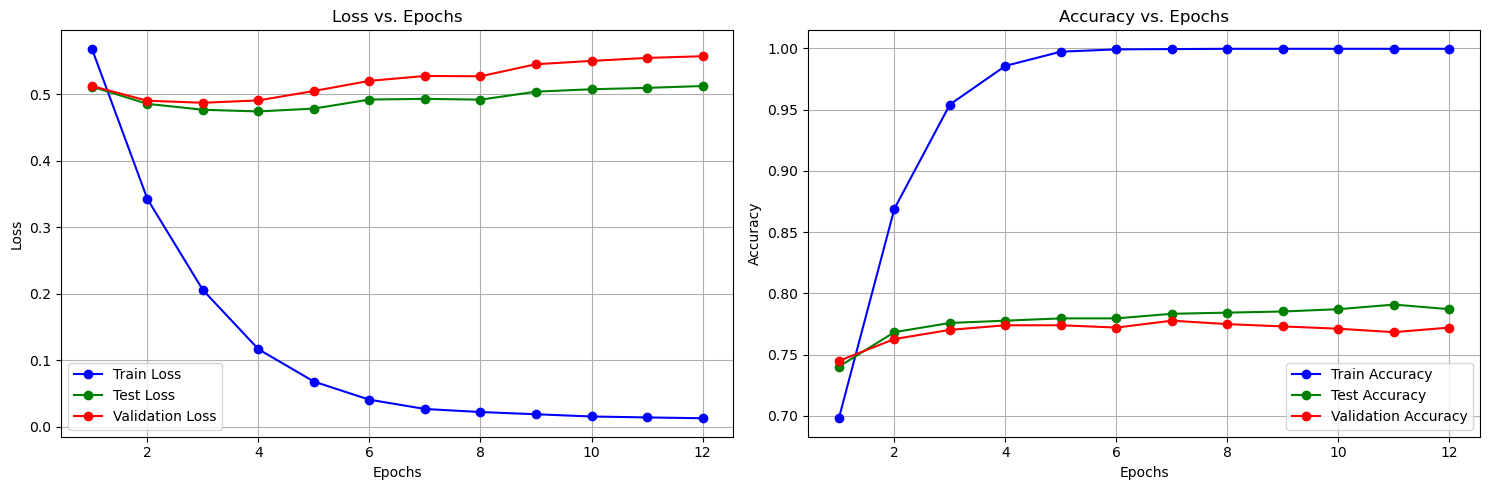

In [80]:
# Plotting Loss and Accuracy against Epochs
plot_metrics(train_losses, train_accuracies, test_losses, test_accuracies, val_losses, val_accuracies)

In [82]:
# Final evaluation on the validation set to compare whether model is correct
cnn_val_loss, cnn_val_accuracy = evaluate(cnn_model, val_loader, criterion)
print(f"Validation Loss: {cnn_val_loss:.4f}, Validation Accuracy: {cnn_val_accuracy:.4f}")

Validation Loss: 0.5275, Validation Accuracy: 0.7777


In [83]:
# Final evaluation on the test set
cnn_test_loss, cnn_test_accuracy = evaluate(cnn_model, test_loader, criterion)
print(f"Test Loss: {cnn_test_loss:.4f}, Test Accuracy: {cnn_test_accuracy:.4f}")

Test Loss: 0.4931, Test Accuracy: 0.7833


# Answers to Question 3(c) and 3(d)

### 3(c) Report the accuracy scores of biLSTM and biGRU on the test set

In [193]:
# Print the Test Accuracies for biLSTM and biGRU for all the layers
print(f"BiLSTM (2 Layers) Test Accuracy: {bilstm_2_test_accuracy:.4f}")
print(f"BiLSTM (3 Layers) Test Accuracy: {bilstm_3_test_accuracy:.4f}")
print(f"BiLSTM (4 Layers) Test Accuracy: {bilstm_4_test_accuracy:.4f}")
print(f"BiLSTM with Dropout (2 Layers) Test Accuracy: {bilstm_dropout_2_test_accuracy:.4f}")
print(f"BiLSTM with Dropout (3 Layers) Test Accuracy: {bilstm_dropout_3_test_accuracy:.4f}")
print(f"BiLSTM with Dropout (4 Layers) Test Accuracy: {bilstm_dropout_4_test_accuracy:.4f}")
print(f"BiGRU (2 Layers) Test Accuracy: {bigru_2_test_accuracy:.4f}")
print(f"BiGRU (3 Layers) Test Accuracy: {bigru_3_test_accuracy:.4f}")
print(f"BiGRU (4 Layers) Test Accuracy: {bigru_4_test_accuracy:.4f}")

BiLSTM (2 Layers) Test Accuracy: 0.7402
BiLSTM (3 Layers) Test Accuracy: 0.7411
BiLSTM (4 Layers) Test Accuracy: 0.7430
BiLSTM with Dropout (2 Layers) Test Accuracy: 0.7523
BiLSTM with Dropout (3 Layers) Test Accuracy: 0.7533
BiLSTM with Dropout (4 Layers) Test Accuracy: 0.7570
BiGRU (2 Layers) Test Accuracy: 0.7533
BiGRU (3 Layers) Test Accuracy: 0.7345
BiGRU (4 Layers) Test Accuracy: 0.7420


| Method              | Test Accuracy (2 Layers) | Test Accuracy (3 Layers) | Test Accuracy (4 Layers) |
|---------------------|-----------------------|-------------------------|-------------------------|
| BiLSTM Model              | 0.7402               | 0.7411               | 0.7430                         |
| BiLSTM with Dropout Model | 0.7523               | 0.7533               | 0.7570                         |
| BiGRU Model               | 0.7533               | 0.7345               | 0.7420                         |

From the results shown above, we can see that the test accuracies of BiLSTM model improved as the number of layers increased. However, the test accuracies of BiGRU model did not improve significantly as the number of layers increased

### 3(d) Report the accuracy scores of CNN on the test set

In [170]:
# Print the Test Accuracy for CNN
print(f"CNN Test Accuracy: {cnn_test_accuracy:.4f}")

CNN Test Accuracy: 0.7833


| Method              | Test Accuracy | 
|---------------------|-----------------------|
| CNN Model    | 0.7833              | 

From both the results shown in 3(c) and 3(d), we can see that the test accuracy of the CNN model is the highest having ```78.33%``` accuracy compared to any BiLSTM or BiGRU model.